In [ ]:
!nvidia-smi

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2023-06-26 16:22:07--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  21.0MB/s    in 95s     

2023-06-26 16:23:42 (20.2 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [ ]:
!tar -xvf  'VOCtrainval_11-May-2012.tar'

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import os
import torch
import torchvision
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import albumentations as A
import cv2
import pandas as pd

In [ ]:
def read_voc_images_names(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    imgs_names, labels_names = [], []
    for i, fname in enumerate(images):
        imgs_names.append(os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg'))
        labels_names.append(os.path.join(voc_dir, 'SegmentationClass' ,f'{fname}.png'))
    return imgs_names, labels_names

In [ ]:
#imgs_names, labels_names = read_voc_images_names('VOCdevkit/VOC2012', True)
#
#
#img = cv2.cvtColor(cv2.imread(imgs_names[0]), cv2.COLOR_BGR2RGB)
#label = cv2.cvtColor(cv2.imread(labels_names[0]), cv2.COLOR_BGR2RGB)
#
#plt.figure()
#plt.imshow(img)
#plt.figure()
#plt.imshow(label)
#
#
#
#alb = A.GaussNoise(p=1)
#d = alb(image = img)
#
#plt.figure()
#plt.imshow(d['image'])


In [ ]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_UNIQUE = { (((k[0]*256)+k[1])*256 + k[2]): i for (i, k) in enumerate(VOC_COLORMAP) }


VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

num_classes = len(VOC_CLASSES)

# pixel of edge - [224, 224, 192], code of this pixel - 14737600
NUM_OF_EDGE = 14737600


HEIGHT = 256
WIDTH = 256

train_transform = A.Compose([A.HueSaturationValue(),
                             A.GaussNoise(),
                             A.HorizontalFlip(),
                             A.Rotate(limit = (-45, 45)),
                             A.Resize(height=HEIGHT, width=WIDTH)])

valid_transform = A.Compose([A.Resize(height=HEIGHT, width=WIDTH)])

In [ ]:
def RGB_label_to_mask(label):
  h, w, _ = label.shape
  label = label.astype(np.int64)

  label = ((label[:, :, 0]*256) + label[:, :, 1])*256 + label[:, :, 2]


  unique = np.unique(label)
  mask = np.zeros((num_classes, h, w))

  for code in unique:
    if code == NUM_OF_EDGE:
      continue
    if code==0:
      np.putmask(mask[0, :, :], np.logical_or(label==0, label==NUM_OF_EDGE), 1)  # edge = background
    else:
      np.putmask(mask[VOC_UNIQUE[code], :, :], (label==code), 1)

  return mask

In [ ]:
def aug(img, label, transform):
    img = img
    label = label
    transformed = transform(image=img, mask=label)

    img, label = transformed['image'], transformed['mask']

    return img, label


In [ ]:
from typing_extensions import Self
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, voc_dir):

        self.is_train = is_train


        imgs_names, labels_names = read_voc_images_names(voc_dir, is_train=is_train)
        self.imgs_names = imgs_names
        self.labels_names = labels_names

        self.transform = None
        if is_train:
          self.transform = train_transform
        else:
          self.transform = valid_transform

        print('read ' + str(len(self.imgs_names)) + ' examples')

    def __getitem__(self, idx):
        img_name = self.imgs_names[idx]
        label_name = self.labels_names[idx]

        img = cv2.cvtColor(cv2.imread(img_name), cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(cv2.imread(label_name), cv2.COLOR_BGR2RGB)

        img, label = aug(img, label, self.transform)

        img = img.astype(float)
        label = label.astype(float)
        img /= 255

        return (torch.tensor(img, dtype=torch.float64).permute(2, 0, 1), torch.tensor(RGB_label_to_mask(label)))

    def __len__(self):
        return len(self.imgs_names)



In [ ]:
#[bs, num, h, w]

In [ ]:
crop_size = (256, 256)
voc_train = VOCSegDataset(True, 'VOCdevkit/VOC2012')
voc_test = VOCSegDataset(False, 'VOCdevkit/VOC2012')

read 1464 examples
read 1449 examples


In [ ]:
batch_size = 12
train_loader = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(voc_test, batch_size, shuffle=False, drop_last=True, num_workers=2)

In [ ]:
for X, Y in train_loader:
  print(X.shape)
  print(Y.shape)
  break


torch.Size([12, 3, 256, 256])
torch.Size([12, 21, 256, 256])


In [ ]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-b6i6g0gu
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-b6i6g0gu
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e5d3db20e9c2ddb76f88642409e527239943c983
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.1 MB/s eta 0:00:00
  Created wheel f

In [ ]:
!pip install --force-reinstall git+https://github.com/qubvel/segmentation_models.pytorch==0.2.1

In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = smp.FPN(encoder_name = 'efficientnet-b0', classes = num_classes, activation = 'softmax')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 82.3MB/s]


In [ ]:
model.load_state_dict(torch.load('/content/content/MyDrive/FPN_3_DL+CE_9.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
class IoU(torch.nn.Module):
    __name__="IoU"
    def __init__(self, mode='MULTILABEL_MODE', threshold=0.4):
        assert mode in ['MULTILABEL_MODE']
        super(IoU, self).__init__()
        self.mode = mode
        self.threshold = threshold


    def forward(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        '''
        Args:
            X - model prediction, (batch_size, num_classes, height, width)
            Y - label, (batch_size, num_classes, height, width)
        '''
        batch_size, num_classes, height, width = X.shape

        X = torch.where(X >= self.threshold, 1, 0)

        X = X.view(batch_size, num_classes, -1)
        Y = Y.view(batch_size, num_classes, -1)

        tp = (X * Y).sum(2)
        fp = X.sum(2) - tp
        fn = Y.sum(2) - tp
        tn = torch.tensor(height*width) - (tp + fp + fn)

        return torch.nanmean(tp / (tp+fp+fn), axis=0)

In [ ]:
iou = IoU()

In [ ]:
def train_model(model, train_loader, loss1, loss2, optimizer, scheduler, num_epochs):
    df = pd.DataFrame([], columns=['lr', 'loss', 'ave_iou'] + VOC_CLASSES)
    loss_history = []
    iou_history = defaultdict(list)

    counter_to_stop = 0
    best_iou = 0.

    for epoch in range(num_epochs):
        model.train()

        loss_accum = 0
        ave_iou_per_ep = defaultdict(list)

        for (x, y) in tqdm(train_loader):

            optimizer.zero_grad()

            x_gpu = x.float().to(device)
            y_gpu = y.float().to(device)
            prediction = model(x_gpu)
            loss_value1 = loss1(prediction, y_gpu)
            loss_value2 = loss2(prediction, y_gpu)
            loss = 0.6*loss_value1 + 0.4*loss_value2

            for (key, score) in zip(VOC_CLASSES, iou(prediction, y_gpu)):
                ave_iou_per_ep[key].append(score)

            loss.backward()
            optimizer.step()

            loss_accum += loss


        new_df_row = []
        for param_group in optimizer.param_groups:
            new_df_row.append(param_group['lr'])

        ave_loss = (loss_accum / len(train_loader)).item()

        new_df_row.append(ave_loss)

        ave_iou = 0
        ave_iou_per_class = []
        for key in ave_iou_per_ep:
          tmp = torch.nanmean(torch.tensor(ave_iou_per_ep[key], dtype=float)).item()
          ave_iou_per_class.append(tmp)

          ave_iou += tmp
          iou_history[key].append(tmp)
        ave_iou /= num_classes

        new_df_row.append(ave_iou)
        new_df_row += ave_iou_per_class
        df.loc[len(df.index)] = new_df_row

        df.to_csv("/content/content/MyDrive/df_CAWR.csv", index=False)

        torch.save(model.state_dict(), "/content/content/MyDrive/Last_CAWR.pth")
        if ave_iou > best_iou:
          best_iou = ave_iou
          counter_to_stop = 0
          torch.save(model.state_dict(), "/content/content/MyDrive/Best_CAWR.pth")
        else:
          counter_to_stop += 1
          if counter_to_stop == 10:
            return loss_history, iou_history, df

        if scheduler is not None:
          scheduler.step()

        loss_history.append(float(ave_loss))

        print("Epoh: " + str(epoch))
        print("lr: " + str(new_df_row[0]))
        print("Average loss: %f" % (ave_loss))
        print("Average iou: %f" % (ave_iou))
        print()

    #print("Average IoU of all epochs:", ave_iou)
    return loss_history, iou_history, df

In [ ]:
model = model.to(device)
parameters = model.parameters()

Dloss = smp.losses.DiceLoss(mode='multilabel', from_logits=False)
CEloss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(parameters, lr=0.000625)
num_epochs = 130
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0 = 10, eta_min=0.0000625)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=15, eta_min=0.0000625)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.8)
#scheduler = None
loss_history, iou_history, df = train_model(model, train_loader, Dloss, CEloss, optimizer, scheduler, num_epochs)

#min etta


  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.89it/s]


Epoh: 0
lr: 0.0006250000000000001
Average loss: 1.266395
Average iou: 0.039118



100%|██████████| 122/122 [01:06<00:00,  1.85it/s]


Epoh: 1
lr: 0.000611234645208012
Average loss: 1.225680
Average iou: 0.068731



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoh: 2
lr: 0.0005712860296679541
Average loss: 1.205825
Average iou: 0.083236



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 3
lr: 0.0005090646022072581
Average loss: 1.186089
Average iou: 0.097184



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:06<00:00,  1.82it/s]


Epoh: 4
lr: 0.000430661029667954
Average loss: 1.186375
Average iou: 0.102009



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoh: 5
lr: 0.00034375000000000003
Average loss: 1.180391
Average iou: 0.114276



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.91it/s]


Epoh: 6
lr: 0.00025683897033204606
Average loss: 1.174265
Average iou: 0.127249



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.92it/s]


Epoh: 7
lr: 0.00017843539779274198
Average loss: 1.170594
Average iou: 0.134733



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.91it/s]


Epoh: 8
lr: 0.00011621397033204607
Average loss: 1.168836
Average iou: 0.132626



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.89it/s]


Epoh: 9
lr: 7.626535479198807e-05
Average loss: 1.163811
Average iou: 0.140413



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 10
lr: 0.0006250000000000001
Average loss: 1.177884
Average iou: 0.119496



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoh: 11
lr: 0.000611234645208012
Average loss: 1.176991
Average iou: 0.130563



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:05<00:00,  1.86it/s]


Epoh: 12
lr: 0.0005712860296679541
Average loss: 1.173486
Average iou: 0.130821



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 13
lr: 0.0005090646022072581
Average loss: 1.168589
Average iou: 0.141532



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 14
lr: 0.000430661029667954
Average loss: 1.162161
Average iou: 0.145770



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.90it/s]


Epoh: 15
lr: 0.00034375000000000003
Average loss: 1.144376
Average iou: 0.159733



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 16
lr: 0.00025683897033204606
Average loss: 1.139873
Average iou: 0.166859



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.92it/s]


Epoh: 17
lr: 0.00017843539779274198
Average loss: 1.134439
Average iou: 0.180975



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.88it/s]


Epoh: 18
lr: 0.00011621397033204607
Average loss: 1.127599
Average iou: 0.192104



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 19
lr: 7.626535479198807e-05
Average loss: 1.126262
Average iou: 0.196741



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 20
lr: 0.0006250000000000001
Average loss: 1.140199
Average iou: 0.174808



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:06<00:00,  1.84it/s]


Epoh: 21
lr: 0.000611234645208012
Average loss: 1.146022
Average iou: 0.167043



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoh: 22
lr: 0.0005712860296679541
Average loss: 1.143915
Average iou: 0.152937



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:05<00:00,  1.87it/s]


Epoh: 23
lr: 0.0005090646022072581
Average loss: 1.137955
Average iou: 0.172216



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.97it/s]


Epoh: 24
lr: 0.000430661029667954
Average loss: 1.127535
Average iou: 0.185200



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 25
lr: 0.00034375000000000003
Average loss: 1.124394
Average iou: 0.196339



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:05<00:00,  1.85it/s]


Epoh: 26
lr: 0.00025683897033204606
Average loss: 1.122882
Average iou: 0.213058



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 27
lr: 0.00017843539779274198
Average loss: 1.115079
Average iou: 0.209453



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoh: 28
lr: 0.00011621397033204607
Average loss: 1.117664
Average iou: 0.218610



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.89it/s]


Epoh: 29
lr: 7.626535479198807e-05
Average loss: 1.119104
Average iou: 0.222091



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoh: 30
lr: 0.0006250000000000001
Average loss: 1.129204
Average iou: 0.206708



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.92it/s]


Epoh: 31
lr: 0.000611234645208012
Average loss: 1.136676
Average iou: 0.178787



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.88it/s]


Epoh: 32
lr: 0.0005712860296679541
Average loss: 1.131015
Average iou: 0.192717



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 33
lr: 0.0005090646022072581
Average loss: 1.124464
Average iou: 0.190602



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.92it/s]


Epoh: 34
lr: 0.000430661029667954
Average loss: 1.124718
Average iou: 0.213122



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:07<00:00,  1.81it/s]


Epoh: 35
lr: 0.00034375000000000003
Average loss: 1.120504
Average iou: 0.210798



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 36
lr: 0.00025683897033204606
Average loss: 1.119421
Average iou: 0.221344



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:06<00:00,  1.84it/s]


Epoh: 37
lr: 0.00017843539779274198
Average loss: 1.113847
Average iou: 0.220693



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoh: 38
lr: 0.00011621397033204607
Average loss: 1.108861
Average iou: 0.250871



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 39
lr: 7.626535479198807e-05
Average loss: 1.109087
Average iou: 0.246071



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:06<00:00,  1.82it/s]


Epoh: 40
lr: 0.0006250000000000001
Average loss: 1.107708
Average iou: 0.227520



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.90it/s]


Epoh: 41
lr: 0.000611234645208012
Average loss: 1.120525
Average iou: 0.200035



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 42
lr: 0.0005712860296679541
Average loss: 1.120705
Average iou: 0.198221



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.88it/s]


Epoh: 43
lr: 0.0005090646022072581
Average loss: 1.117414
Average iou: 0.198344



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.91it/s]


Epoh: 44
lr: 0.000430661029667954
Average loss: 1.110870
Average iou: 0.212277



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoh: 45
lr: 0.00034375000000000003
Average loss: 1.106430
Average iou: 0.239461



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.90it/s]


Epoh: 46
lr: 0.00025683897033204606
Average loss: 1.098926
Average iou: 0.247158



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.99it/s]


Epoh: 47
lr: 0.00017843539779274198
Average loss: 1.100425
Average iou: 0.255179



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 48
lr: 0.00011621397033204607
Average loss: 1.101961
Average iou: 0.258225



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:06<00:00,  1.84it/s]


Epoh: 49
lr: 7.626535479198807e-05
Average loss: 1.095012
Average iou: 0.257179



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoh: 50
lr: 0.0006250000000000001
Average loss: 1.105254
Average iou: 0.228234



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 51
lr: 0.000611234645208012
Average loss: 1.112416
Average iou: 0.224997



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoh: 52
lr: 0.0005712860296679541
Average loss: 1.111920
Average iou: 0.202134



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoh: 53
lr: 0.0005090646022072581
Average loss: 1.106642
Average iou: 0.220749



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:06<00:00,  1.82it/s]


Epoh: 54
lr: 0.000430661029667954
Average loss: 1.112637
Average iou: 0.213468



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 55
lr: 0.00034375000000000003
Average loss: 1.102910
Average iou: 0.234329



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoh: 56
lr: 0.00025683897033204606
Average loss: 1.101046
Average iou: 0.263369



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoh: 57
lr: 0.00017843539779274198
Average loss: 1.095473
Average iou: 0.267623



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.99it/s]


Epoh: 58
lr: 0.00011621397033204607
Average loss: 1.096457
Average iou: 0.265836



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 59
lr: 7.626535479198807e-05
Average loss: 1.095095
Average iou: 0.276240



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:06<00:00,  1.84it/s]


Epoh: 60
lr: 0.0006250000000000001
Average loss: 1.102392
Average iou: 0.254612



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoh: 61
lr: 0.000611234645208012
Average loss: 1.102921
Average iou: 0.227656



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 62
lr: 0.0005712860296679541
Average loss: 1.108909
Average iou: 0.212903



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.89it/s]


Epoh: 63
lr: 0.0005090646022072581
Average loss: 1.105412
Average iou: 0.234367



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 64
lr: 0.000430661029667954
Average loss: 1.101496
Average iou: 0.252908



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoh: 65
lr: 0.00034375000000000003
Average loss: 1.094164
Average iou: 0.255385



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.90it/s]


Epoh: 66
lr: 0.00025683897033204606
Average loss: 1.095447
Average iou: 0.256862



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoh: 67
lr: 0.00017843539779274198
Average loss: 1.093951
Average iou: 0.281694



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoh: 68
lr: 0.00011621397033204607
Average loss: 1.089271
Average iou: 0.283146



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:05<00:00,  1.87it/s]


Epoh: 69
lr: 7.626535479198807e-05
Average loss: 1.091883
Average iou: 0.291562



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoh: 70
lr: 0.0006250000000000001
Average loss: 1.094082
Average iou: 0.253762



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoh: 71
lr: 0.000611234645208012
Average loss: 1.096021
Average iou: 0.242172



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.93it/s]


Epoh: 72
lr: 0.0005712860296679541
Average loss: 1.099330
Average iou: 0.244094



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoh: 73
lr: 0.0005090646022072581
Average loss: 1.100564
Average iou: 0.246726



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:05<00:00,  1.85it/s]


Epoh: 74
lr: 0.000430661029667954
Average loss: 1.094825
Average iou: 0.255587



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 75
lr: 0.00034375000000000003
Average loss: 1.087977
Average iou: 0.264407



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoh: 76
lr: 0.00025683897033204606
Average loss: 1.089334
Average iou: 0.287317



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.91it/s]


Epoh: 77
lr: 0.00017843539779274198
Average loss: 1.089739
Average iou: 0.301208



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoh: 78
lr: 0.00011621397033204607
Average loss: 1.087276
Average iou: 0.292562



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:03<00:00,  1.91it/s]


Epoh: 79
lr: 7.626535479198807e-05
Average loss: 1.088154
Average iou: 0.303516



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoh: 80
lr: 0.0006250000000000001
Average loss: 1.094538
Average iou: 0.274490



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.94it/s]


Epoh: 81
lr: 0.000611234645208012
Average loss: 1.099359
Average iou: 0.251666



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.98it/s]


Epoh: 82
lr: 0.0005712860296679541
Average loss: 1.095334
Average iou: 0.253117



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.95it/s]


Epoh: 83
lr: 0.0005090646022072581
Average loss: 1.085581
Average iou: 0.251047



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.90it/s]


Epoh: 84
lr: 0.000430661029667954
Average loss: 1.073451
Average iou: 0.273925



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 85
lr: 0.00034375000000000003
Average loss: 1.063464
Average iou: 0.283389



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:01<00:00,  1.97it/s]


Epoh: 86
lr: 0.00025683897033204606
Average loss: 1.062721
Average iou: 0.294955



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 87
lr: 0.00017843539779274198
Average loss: 1.061791
Average iou: 0.300960



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 88
lr: 0.00011621397033204607
Average loss: 1.060850
Average iou: 0.312892



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 89
lr: 7.626535479198807e-05
Average loss: 1.057894
Average iou: 0.321869



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:04<00:00,  1.90it/s]


Epoh: 90
lr: 0.0006250000000000001
Average loss: 1.061373
Average iou: 0.291219



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [01:02<00:00,  1.96it/s]


Epoh: 91
lr: 0.000611234645208012
Average loss: 1.064811
Average iou: 0.280414



  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
 35%|███▌      | 43/122 [00:22<00:40,  1.95it/s]


KeyboardInterrupt: ignored

In [ ]:
df

In [ ]:
df.to_csv("/content/content/MyDrive/CosineAnnealingLR.csv", index=False)

In [ ]:
plt.plot(np.arange(0, num_epochs), np.array(loss_history))
plt.title('loss')
plt.show()

for cls in VOC_CLASSES:
  plt.plot(np.arange(0, num_epochs), np.array(iou_history[cls]))
  plt.title(cls)
  plt.show()


In [ ]:
d = {'background': 0.9143902937896916, 'aeroplane': 0.5900697390499868, 'bicycle': 0.17467998426848202, 'bird': 0.5717718278089267, 'boat': 0.5660091694706763, 'bottle': 0.29275987471671816, 'bus': 0.561876617372036, 'car': 0.4870526874528348, 'cat': 0.5734384903813353, 'chair': 0.2803908920752893, 'cow': 0.5710069142855131, 'diningtable': 0.549999515441331, 'dog': 0.5062069438543975, 'horse': 0.472665530133557, 'motorbike': 0.44126948416233064, 'person': 0.4441989294451768, 'potted plant': 0.2771284450786282, 'sheep': 0.5606630342220192, 'sofa': 0.4532090984284878, 'train': 0.6405635722478231, 'tv/monitor': 0.5607955859948511}
ave = 0
for key in d.keys():
  ave += d[key]
print(ave/21)

0.4995307918895281


[('background', 0.8553271872369259), ('boat', 0.771858228980322), ('car', 0.5583224115334207)]


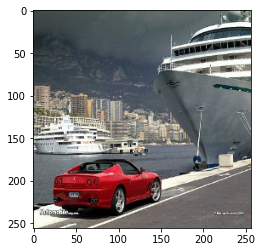

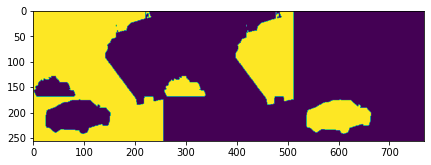

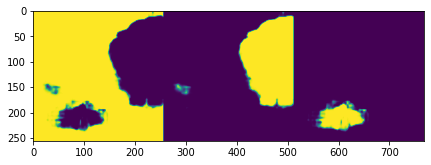

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

model.eval()

im, mask = voc_train[202]

#mask = mask.to(device)

u = torch.unique(mask)
plt.figure()
plt.imshow(im.permute(1, 2, 0))

#im = im.to(device)

im = im.view(1, 3, 256, 256)
x = model(im.float())



indices = []
for i in range(num_classes):
  if torch.max(mask[i]) == 1:
    indices.append(i)




m = iou(x, mask)
available_m = []
for i in indices:
  available_m.append((VOC_CLASSES[i], m[i].item()))

print(available_m)

targ = []
pred = []
for i in range(mask.size(0)):
  if i==0 or torch.max(mask[i]!=0):
    targ.append(mask[i])
    pred.append(x[0, i])

targ = torch.cat(targ, dim=1)
pred = torch.cat(pred, dim=1)
fsize = (7, 7)
plt.figure(figsize=fsize)
plt.imshow(targ.detach().cpu().numpy())
plt.figure(figsize=fsize)
plt.imshow(pred.detach().cpu().numpy())


In [ ]:
im, mask = voc_train[101]

#mask = mask.to(device)

u = torch.unique(mask)
plt.figure()
plt.imshow(im.permute(1, 2, 0))


targ = []
for i in range(mask.size(0)):
  if i==0 or torch.max(mask[i]!=0):
    targ.append(mask[i])
targ = torch.cat(targ, dim=1)
fsize = (7, 7)
plt.figure(figsize=fsize)
plt.imshow(targ.detach().cpu().numpy())

#im = im.to(device)
#im = im.view(1, 3, 256, 256)
#x = model(im.float())

In [ ]:
df_None = pd.read_csv('/content/content/MyDrive/df_None.csv')
#display(df_None)

In [ ]:
df_StepLR = pd.read_csv('/content/content/MyDrive/df_StepLR.csv')
#display(df_StepLR)

In [ ]:
df_CALR = pd.read_csv('/content/content/MyDrive/df_CALR.csv')

In [ ]:
df_CAWR = pd.read_csv('/content/content/MyDrive/df_CAWR.csv')

<Axes: >

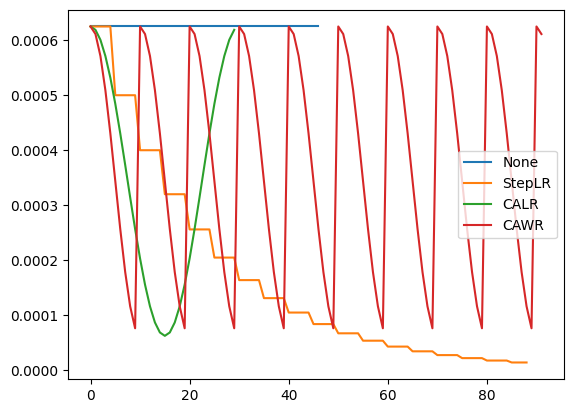

In [ ]:
key = 'lr'
df_None[key].plot(label = 'None', legend = True)
df_StepLR[key].plot(label = 'StepLR', legend = True)
df_CALR[key].plot(label = 'CALR', legend = True)
df_CAWR[key].plot(label = 'CAWR', legend = True)

In [ ]:
df_None.columns

Index(['lr', 'loss', 'ave_iou', 'background', 'aeroplane', 'bicycle', 'bird',
       'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
       'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa',
       'train', 'tv/monitor'],
      dtype='object')

<Axes: >

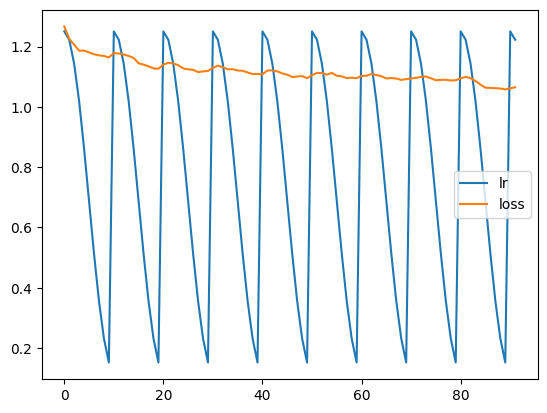

In [ ]:
(df_CAWR['lr']*2000).plot(label = 'lr', legend = True)
df_CAWR['loss'].plot(label = 'loss', legend = True)

In [ ]:
df_CAWR['lr']

0     0.000625
1     0.000611
2     0.000571
3     0.000509
4     0.000431
        ...   
87    0.000178
88    0.000116
89    0.000076
90    0.000625
91    0.000611
Name: lr, Length: 92, dtype: float64

In [ ]:
def val(model, val_loader):
    iou_history = defaultdict(list)
    model.eval()
    ave_iou_per_ep = defaultdict(list)
    for (x, y) in tqdm(val_loader):
        x = x.float()
        y = y.float()
        prediction = model(x)
        for (key, score) in zip(VOC_CLASSES, iou(prediction, y)):
            ave_iou_per_ep[key].append(score)
    ave_iou = 0
    ave_iou_per_class = []
    for key in ave_iou_per_ep:
      tmp = torch.nanmean(torch.tensor(ave_iou_per_ep[key], dtype=float)).item()
      ave_iou_per_class.append(tmp)
      ave_iou += tmp
      iou_history[key].append(tmp)
    ave_iou /= num_classes
    print("Average iou: %f" % (ave_iou))
    print()

    #print("Average IoU of all epochs:", ave_iou)
    return iou_history

In [ ]:
iou_history = val(model, val_loader)

  0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 120/120 [06:05<00:00,  3.05s/it]

Average iou: 0.303831



In [ ]:
iou_history

defaultdict(list,
            {'background': [0.8715230166912079],
             'aeroplane': [0.5310773165293143],
             'bicycle': [0.1428356701460191],
             'bird': [0.32020883167889425],
             'boat': [0.2843934684889774],
             'bottle': [0.1594215607477559],
             'bus': [0.4337492776356395],
             'car': [0.29055970826363925],
             'cat': [0.3643815552825298],
             'chair': [0.05991571208273637],
             'cow': [0.24893857090722157],
             'diningtable': [0.18640907995633027],
             'dog': [0.2605267653980424],
             'horse': [0.2763360150454987],
             'motorbike': [0.25006636407366994],
             'person': [0.3860857306669156],
             'potted plant': [0.11465894770143288],
             'sheep': [0.31146735162179495],
             'sofa': [0.19881767181826657],
             'train': [0.34838197752833366],
             'tv/monitor': [0.3406865264118557]})

In [ ]:
iou_history_train = val(model, train_loader)

  0%|          | 0/122 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 122/122 [06:09<00:00,  3.02s/it]

Average iou: 0.592134



In [ ]:
iou_history_train

defaultdict(list,
            {'background': [0.9115948452324164],
             'aeroplane': [0.7056924198100816],
             'bicycle': [0.25906956818566396],
             'bird': [0.6518381871283054],
             'boat': [0.681926091275518],
             'bottle': [0.36694404595930663],
             'bus': [0.7352294289148771],
             'car': [0.5946183354977299],
             'cat': [0.68094934589333],
             'chair': [0.35577747370432883],
             'cow': [0.5397935077763986],
             'diningtable': [0.6092754939328069],
             'dog': [0.5431317252417406],
             'horse': [0.5547591072972864],
             'motorbike': [0.5809272738064036],
             'person': [0.5131820880609458],
             'potted plant': [0.34853666072542017],
             'sheep': [0.7621793403393693],
             'sofa': [0.5854162716617187],
             'train': [0.7793768186009291],
             'tv/monitor': [0.674590711410229]})